In [12]:
from nltk.tokenize import RegexpTokenizer
import numpy as np
import re
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
import random,copy,string
import matplotlib.pyplot as plt
import nltk
import multiprocessing as mp
import random,copy,string
from scipy.stats import pearsonr
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Conv1D,  MaxPool1D, Flatten
from tensorflow.python.keras.layers import Lambda, multiply, concatenate, Dense
from tensorflow.python.keras.callbacks import Callback
# from keras.optimizers import Adam
import tensorflow as tf
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [35]:
from keras import models

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###HYPER - PARAMETERS

In [6]:
sentence_length, padding_size = 40,40
embedding_size = 300
no_of_filters = 300
kernel_size = 1
cnn_activation_function = 'relu'
cnn_kernel_initializer = 'he_uniform'
no_of_units_ds1 = 300
output_units = 6
optimizer = 'adam'
batch_size = 300
num_batches = 2

### Glove embedding

In [7]:
word_to_index = dict()
index_to_word = dict()
index = 1
embed_dict = {}
embed_dict['oov'] = np.zeros(300)

with open('/content/drive/MyDrive/Colab Notebooks/Working/glove.6B.300d.txt','r') as f:  #/content/drive/MyDrive/NLP/glove.840B.300d.txt /content/drive/MyDrive/smai/glove/glove.6B.300d.txt
  for line in f:
    values = line.split(' ')
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embed_dict[word]=vector
    word_to_index[word] = index
    index_to_word[index] = word
    index+=1

word_to_index['oov'] = 0
index_to_word[0] = 'oov'

### Data Pre-Processing 

In [8]:
def generate_embedding_matrix(sentence):

    tokens_ = nltk.word_tokenize(sentence)
    tokens = []

    for i in tokens_:
      if i not in string.punctuation:
        tokens.append(i.lower())
    # sentence = sentence.lower()
    # sentence = re.sub('[^a-z0-9]',' ',sentence)
    # Tokenize the sentence and do the padding
    
    word_to_vec = []
    # Loop over the tokens and generate their embeddings
    for i, token in enumerate(tokens):
        if token in word_to_index:
            word_to_vec.append(word_to_index[token])
        else:
            word_to_vec.append(word_to_index['oov'])

    # print(word_to_vec)

    word_to_vec = np.array(word_to_vec)
    word_to_vec=word_to_vec.reshape(1,word_to_vec.shape[0])
    word_to_vec = pad_sequences(word_to_vec, maxlen=sentence_length, truncating='post', padding='post')

    # Initialize an empty matrix with shape (sentence_length, 300)
    embedding_matrix = np.zeros((sentence_length, 300))
    
    # Loop over the tokens and generate their embeddings
    for i, token in enumerate(word_to_vec[0]):
        embedding_matrix[i, :] = embed_dict[index_to_word[token]]
    return embedding_matrix

In [9]:
def get_input(filename):
  with open(filename) as f:
    lines = [line.rstrip('\n') for line in f]
  s1_embedding_matrix_list,s2_embedding_matrix_list,actual_scores = list(),list(),list()
  for line in lines:
    # _,_,_,_,score,s1,s2 = line.split('\t')[:7]
    s1,s2,score = line.split('\t')
    s1_embedding_matrix_list.append(generate_embedding_matrix(s1))
    s2_embedding_matrix_list.append(generate_embedding_matrix(s2))
    actual_scores.append(eval(score))

  s1_embedding_matrix_list = np.array(s1_embedding_matrix_list)
  s2_embedding_matrix_list = np.array(s2_embedding_matrix_list)
  actual_scores = np.array(actual_scores)
  return s1_embedding_matrix_list,s2_embedding_matrix_list,actual_scores

In [10]:
def generate_one_hot_lists(arr):
    # Compute the fractional parts of the array elements
    fracs = np.mod(arr, 1)
    # Compute the distances from the nearest integers
    cfracs = 1 - fracs
    actual =  np.int64(arr - fracs)
    dists = np.minimum(fracs, 1 - fracs)

    # Compute the one-hot encoding of the distances
    one_hots = np.zeros((arr.shape[0], 6))
    for i in range(len(arr)):
      temp = np.zeros(6,)
      if fracs[i] == 0.0:
        temp[actual[i]] = 1.0
      else:
        temp[actual[i]] = cfracs[i]
        temp[actual[i]+1] = fracs[i] 
      one_hots[i,:] = temp 
    return one_hots

In [14]:
train = '/content/drive/MyDrive/Colab Notebooks/Working/en/en-train.txt'
validation ='/content/drive/MyDrive/Colab Notebooks/Working/en/en-val.txt'
test = '/content/drive/MyDrive/Colab Notebooks/Working/en/test-sentences-2017.txt'

train_data, validation_data,  test_data = get_input(train), get_input(validation),  get_input(test)

train_x_1,      train_x_2,      train_y       = train_data[0],      train_data[1],      generate_one_hot_lists(train_data[2]) 
validation_x_1, validation_x_2, validation_y  = validation_data[0], validation_data[1], generate_one_hot_lists(validation_data[2]) 
test_x_1,       test_x_2,       test_y        = test_data[0],       test_data[1],       generate_one_hot_lists(test_data[2]) 

In [15]:
#Analyise Dataset..
def get_avg_sentence_length(sentences):
    # Get the total number of words in all sentences
    total_words = sum([len(sentence.split()) for sentence in sentences])

    # Calculate the average sentence length
    avg_sentence_length = total_words / len(sentences)

    return avg_sentence_length

def plot_sentence_length_variation(sentences):
    # Get the length of each sentence
    sentence_lengths = [len(sentence.split()) for sentence in sentences]

    # Plot the sentence length distribution
    plt.hist(sentence_lengths, bins=range(0, max(sentence_lengths) + 1, 5))
    plt.title('Sentence Length Distribution')
    plt.xlabel('Sentence Length')
    plt.ylabel('Number of Sentences')
    plt.show()


Average sentence length: 11.32315750093528


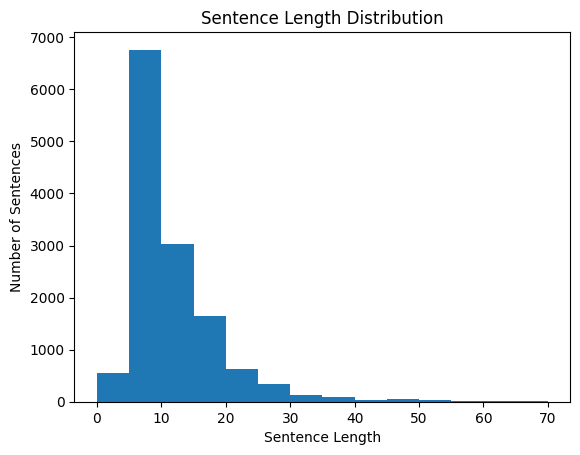

In [16]:
with open(train) as f:
    lines = f.readlines()
s1,s2 = list(),list()
for line in lines:
  a,b,s = line.split('\t')
  s1.append(a)
  s2.append(b)

avg_sentence_length = get_avg_sentence_length(s1)
print('Average sentence length:', avg_sentence_length)
plot_sentence_length_variation(s1)

In [17]:
count = 0
for sentence in s1:
    if len(sentence.split()) <= 40:
        count += 1
print('Number of sentences greater than 40 words:', count)
print('Percentage they are covering:',count/len(s1)*100)

Number of sentences greater than 40 words: 13194
Percentage they are covering: 98.72053872053871


In [18]:
train_x_1.shape,validation_x_1.shape,test_x_1.shape,test_y.shape

((13365, 40, 300), (1500, 40, 300), (250, 40, 300), (250, 6))

### Model

In [19]:
def _lossfunction(y_true,y_pred):
  ny_true = y_true[:,1] + 2*y_true[:,2] + 3*y_true[:,3] + 4*y_true[:,4] + 5*y_true[:,5]
  ny_pred = y_pred[:,1] + 2*y_pred[:,2] + 3*y_pred[:,3] + 4*y_pred[:,4] + 5*y_pred[:,5]
  my_true = K.mean(ny_true)
  my_pred = K.mean(ny_pred)
  var_true = (ny_true - my_true)**2
  var_pred = (ny_pred - my_pred)**2
  return -K.sum((ny_true-my_true)*(ny_pred-my_pred),axis=-1) / (K.sqrt(K.sum(var_true,axis=-1)*K.sum(var_pred,axis=-1)))

In [20]:
sentence1 = Input(shape=(sentence_length,embedding_size))
sentence2 = Input(shape=(sentence_length,embedding_size))
cnn_layer = Conv1D(filters = no_of_filters,
                    kernel_size = kernel_size,
                    activation='relu',
                    kernel_initializer=cnn_kernel_initializer)

cnn_layer1 = cnn_layer(sentence1)
cnn_layer2 = cnn_layer(sentence2)

max_pool = MaxPool1D(pool_size=padding_size-kernel_size+1)

max_pool1 = max_pool(cnn_layer1)
max_pool2 = max_pool(cnn_layer2)
flatten = Flatten()

flatten1 = flatten(max_pool1)
flatten2 = flatten(max_pool2)

absDifference = Lambda(lambda X:K.abs(X[0] - X[1]))([flatten1,flatten2])

mulDifference = multiply([flatten1,flatten2])

allDifference = concatenate([absDifference,mulDifference])

Denselayer_1 = Dense(no_of_units_ds1,activation='tanh',kernel_initializer=cnn_kernel_initializer)(allDifference)

output = Dense(name='output',units=output_units,activation='softmax',kernel_initializer=cnn_kernel_initializer)(Denselayer_1)

model = Model(inputs=[sentence1,sentence2], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 300)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40, 300)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 40, 300)      90300       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 1, 300)       0           conv1d[0][0]                 

In [21]:
model.compile(loss=_lossfunction, optimizer='Adam')

In [22]:
def eval_model(model):
  predictionclasses = list(model.predict([validation_x_1,validation_x_2]))
  prediction = np.dot(np.array(predictionclasses),np.arange(6))
  goldlabels = validation_data[2]
  result=pearsonr(prediction, goldlabels)[0]
  print('Validation PCC:',result)
  return round(result,4)

In [23]:
class Evaluate(Callback):
  def __init__(self, task, wfname):
    self.task       = task
    self.bestresult = 0.0
    self.wfname     = wfname
  def on_epoch_end(self, epoch, logs={}):
    validresult = eval_model(self.task)
    if validresult > self.bestresult:
      self.bestresult = validresult
      self.task.save(self.wfname)

In [24]:
early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=4,
        verbose=1,
        mode="min",
        restore_best_weights=True, 
     )

In [25]:
history = model.fit(x=[train_x_1,train_x_2],
                    y=train_y,
                    callbacks=[Evaluate(model,'/content/drive/MyDrive/Colab Notebooks/Working/best_model_cnn.h5')],
                    batch_size=batch_size,
                    epochs = 60,
                    verbose = 1)

Epoch 1/60
45/45 [==============================] - 14s 270ms/step - loss: -0.7095
Validation PCC: 0.7961227376537485


/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/60
45/45 [==============================] - 11s 246ms/step - loss: -0.8199
Validation PCC: 0.8169356401891952
Epoch 3/60
45/45 [==============================] - 10s 222ms/step - loss: -0.8668
Validation PCC: 0.8223653978937996
Epoch 4/60
45/45 [==============================] - 12s 259ms/step - loss: -0.8990
Validation PCC: 0.8252575411657436
Epoch 5/60
45/45 [==============================] - 12s 268ms/step - loss: -0.9253
Validation PCC: 0.8225406328601435
Epoch 6/60
45/45 [==============================] - 12s 266ms/step - loss: -0.9436
Validation PCC: 0.8154503392613528
Epoch 7/60
45/45 [==============================] - 12s 268ms/step - loss: -0.9556
Validation PCC: 0.8148319465866433
Epoch 8/60
45/45 [==============================] - 12s 261ms/step - loss: -0.9644
Validation PCC: 0.8095340179083588
Epoch 9/60
45/45 [==============================] - 10s 225ms/step - loss: -0.9716
Validation PCC: 0.8030046527649635
Epoch 10/60
45/45 [==============================] - 11s

In [52]:
import re

# Open the text file
with open('/content/Epoch_english.txt', 'r') as file:
    text = file.read()

# Use regular expressions to extract the validation PCC values
pcc_values = re.findall(r'Validation PCC: (\d\.\d+)', text)
pcc_values = [float(x) for x in pcc_values]
print(pcc_values)

[0.7961227376537485, 0.8169356401891952, 0.8223653978937996, 0.8252575411657436, 0.8225406328601435, 0.8154503392613528, 0.8148319465866433, 0.8095340179083588, 0.8030046527649635, 0.8014129343206239, 0.8008368599250011, 0.8012632931919169, 0.7969038257665924, 0.8024189971312577, 0.8026625397026765, 0.8015377799978497, 0.7982824983293471, 0.8013741480205798, 0.8051251803935362, 0.804775039818172, 0.8012532723948564, 0.8048887914753222, 0.8028480219012336, 0.8025243382979563, 0.8022590317532453, 0.8049530979157306, 0.8057105186483882, 0.8001278100850312, 0.807820336881849, 0.8036861728986094, 0.8070958382917518, 0.8073027848681759, 0.8035564687039962, 0.8136423223945363, 0.809500424087112, 0.8130465704546358, 0.8121667198003539, 0.8066350948646673, 0.8110963459810265, 0.8088319637618794, 0.8104937803997248, 0.8099587919118921, 0.8088940927926336, 0.8081998919283561, 0.811433114628097, 0.8140326538113488, 0.8071002207358324, 0.8144779240518729, 0.8113248428743705, 0.814780176314246, 0.81

In [31]:
history.history.keys()

dict_keys(['loss'])

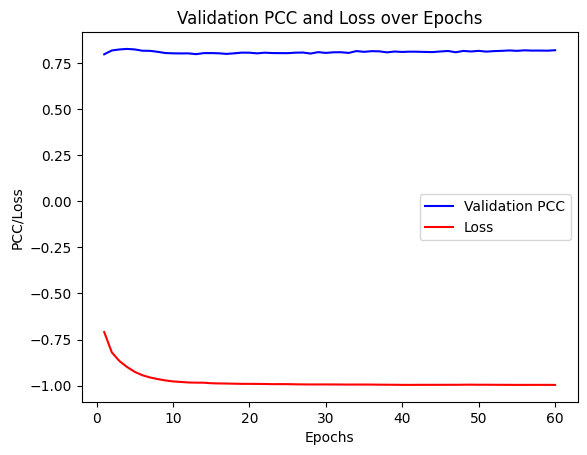

In [53]:
import matplotlib.pyplot as plt

# Extract the validation PCC and loss from the history variable
# val_pcc = history.history['Validation PCC']
loss = history.history['loss']

# Plot the validation PCC and loss over epochs
epochs = range(1, len(loss) + 1)
plt.plot(epochs, pcc_values, 'b', label='Validation PCC')
plt.plot(epochs, loss, 'r', label='Loss')
plt.title('Validation PCC and Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('PCC/Loss')
plt.legend()
plt.show()


In [37]:
from keras.models import load_model

In [38]:
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/Working/best_model_cnn.h5',custom_objects={'_lossfunction': _lossfunction})

In [39]:
predictionclasses = list(model.predict([test_x_1,test_x_2]))
prediction = np.dot(np.array(predictionclasses),np.arange(6))
goldlabels = test_data[2]
pearsonr(np.round(prediction,4), goldlabels)[0]

0.7928529713152234

In [40]:
predictionclasses = list(loaded_model.predict([test_x_1,test_x_2]))
prediction = np.dot(np.array(predictionclasses),np.arange(6))
goldlabels = test_data[2]
pearsonr(np.round(prediction,4), goldlabels)[0]

8/8 [==============================] - 1s 22ms/step


0.8064328544724072

In [49]:
# with open('/content/drive/MyDrive/Colab Notebooks/Working/en/test-sentences-2017.txt') as f:
#   lines = [line.rstrip('\n') for line in f]

In [ ]:
# for i in range(250):
#   a = test_data[2][i]
#   b= np.round(prediction[i],1)
#   if abs(a - b) < 0.5:
#     print(lines[i],a,b) 